# Lab 3: Adversarial Examples Lab

### Introduction

In this lab, we will explore the concept of adversarial examples as introduced in the seminal paper by Goodfellow et al. (2015): "Explaining and Harnessing Adversarial Examples." Adversarial examples are inputs to machine learning models that have been subtly modified to cause the model to make a mistake, while appearing nearly identical to the original input from a human perspective.

### Objectives

1. Understand why neural networks are vulnerable to adversarial examples
2. Implement the Fast Gradient Sign Method (FGSM) to generate adversarial examples
3. Visualize how small, imperceptible perturbations can lead to high-confidence misclassifications

### Implementation

We'll train a simple deep learning model on the MNIST handwritten digit dataset, then apply FGSM to generate adversarial examples that fool our model.

### Setup Instructions

This notebook requires PyTorch and related libraries. If you encounter issues installing these dependencies locally, you can run this notebook in Google Colab, which provides these libraries pre-installed.

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### Data Loading and Preprocessing

In this section, we set up the data pipeline for our experiment:

1. **Device Configuration**: We determine whether to use GPU (CUDA) or CPU for computation.

2. **Data Transformation**: We apply a simple transformation to convert the MNIST images to PyTorch tensors. Unlike many image classification tasks, we don't normalize the pixel values here because MNIST pixel values are already in the range [0,1] after ToTensor()

3. **Dataset Loading**: We load the MNIST dataset, which consists of 28×28 grayscale images of handwritten digits (0-9).
   - Training set: 60,000 examples
   - Test set: 10,000 examples

4. **DataLoader Creation**: We create DataLoader objects that will feed batches of data to our model during training and evaluation.
   - We use a batch size of 64
   - We shuffle the training data to improve model generalization


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

batch_size = 64

train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

### Display Data

Batch shape: torch.Size([64, 1, 28, 28])
Target shape: torch.Size([64])


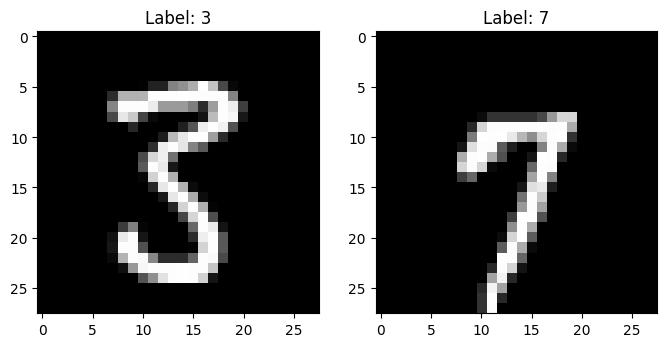

In [62]:
examples = iter(train_loader)
example_data, example_targets = next(examples)

print(f"Batch shape: {example_data.shape}")  # Should be [batch_size, channels, height, width]
print(f"Target shape: {example_targets.shape}")  # Should be [batch_size]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(example_data[0].squeeze(), cmap='gray')
axes[0].set_title(f'Label: {example_targets[0].item()}')
axes[1].imshow(example_data[1].squeeze(), cmap='gray')
axes[1].set_title(f'Label: {example_targets[1].item()}')
plt.show()

### Model Definition

Define a simple neural network for MNIST digit classification. 

Implement a neural network architecture of your choice. For simplicity, we recommend starting with a Multi-Layer Perceptron (MLP) with the following structure:
1. An input layer that flattens the 28x28 MNIST images
2. A hidden layer with 64 neurons and ReLU activation
3. An output layer with 10 neurons (one for each digit 0-9)

For implementation, use PyTorch's nn.Module as the base class and implement:
- The `__init__` method to define your network layers
- The `forward` method to define how data flows through your network

For model components, refer to:
- [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

<details>
  <summary>Hint 1</summary>
  Remember to flatten the input images in the forward method. MNIST images come in shape [batch_size, 1, 28, 28] and need to be reshaped to [batch_size, 784]. Use x = x.view(x.size(0), -1) for this purpose.
</details>

<details>
  <summary>Hint 2</summary>
  When creating your first linear layer, the input size should be 784 (28×28×1) to match the flattened MNIST images.
</details>

In [63]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    
model = Net().to(device)

### Training the Neural Network

Below is a basic training loop for our MNIST classifier. We use CrossEntropyLoss as our loss function, which is the standard choice for multi-class classification problems. For optimization, we employ SGD (Stochastic Gradient Descent).

The training process consists of:
1. Forward pass through the network
2. Loss calculation
3. Gradient computation via backpropagation
4. Parameter updates using the optimizer

In [64]:
learning_rate = 1e-2

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 10

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)           # Step 1: Get predictions
        loss = criterion(outputs, labels) # Step 2: Measure error
        # Backward pass and optimize
        optimizer.zero_grad()             # Step 3: Clear old gradients
        loss.backward()                   # Step 4: Compute new gradients
        optimizer.step()                  # Step 5: Update model weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 1.6535
Epoch [2/10], Loss: 0.5565
Epoch [3/10], Loss: 0.4057
Epoch [4/10], Loss: 0.3540
Epoch [5/10], Loss: 0.3229
Epoch [6/10], Loss: 0.2998
Epoch [7/10], Loss: 0.2802
Epoch [8/10], Loss: 0.2625
Epoch [9/10], Loss: 0.2467
Epoch [10/10], Loss: 0.2320


### Model Evaluation
We evaluate our model's performance by measuring accuracy on the test dataset. This is a simplified approach - in a real environment, we would typically use a separate validation dataset and employ more comprehensive evaluation metrics. However, for the purposes of this notebook, this straightforward evaluation is sufficient to demonstrate the model's baseline performance before we explore adversarial examples.

We’re testing on ‘clean’ images (no tricks yet). A simple MLP should get ~90% accuracy — good, but not perfect.

In [69]:
def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [70]:
eval_acc = evaluate_model(model, test_loader)
print(f"Accuracy on clean test images: {eval_acc:.2f}% (expect ~90%)")

Accuracy on clean test images: 93.63% (expect ~90%)


### Comparing Optimizer Performance

For a challenge, try training with Adam, and Adagrad. Plot their losses. Which converges fastest?

In [36]:
def train_model(optimizer_name, model, train_loader, num_epochs=10, learning_rate=1e-2):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    model.train()
    losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        losses.append(running_loss / len(train_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], {optimizer_name} Loss: {running_loss / len(train_loader):.4f}")

    return losses

In [37]:
# Parameters
num_epochs = 10
learning_rate = 1e-2

# Train the model with Adagrad
model_adagrad = Net()
losses_adagrad = train_model('Adagrad', model_adagrad, train_loader, num_epochs, learning_rate)
eval_acc_adagrad = evaluate_model(model_adagrad, test_loader)
print(f"Accuracy on clean test images with Adagrad: {eval_acc_adagrad:.2f}%")

Epoch [1/10], Adagrad Loss: 0.2962
Epoch [2/10], Adagrad Loss: 0.1695
Epoch [3/10], Adagrad Loss: 0.1394
Epoch [4/10], Adagrad Loss: 0.1210
Epoch [5/10], Adagrad Loss: 0.1086
Epoch [6/10], Adagrad Loss: 0.0993
Epoch [7/10], Adagrad Loss: 0.0918
Epoch [8/10], Adagrad Loss: 0.0856
Epoch [9/10], Adagrad Loss: 0.0806
Epoch [10/10], Adagrad Loss: 0.0762
Accuracy on clean test images with Adagrad: 97.10%


In [38]:
# Train the model with Adam
model_adam = Net()
losses_adam = train_model('Adam', model_adam, train_loader, num_epochs, learning_rate)
eval_acc_adam = evaluate_model(model_adam, test_loader)
print(f"Accuracy on clean test images with Adam: {eval_acc_adam:.2f}%")

Epoch [1/10], Adam Loss: 0.2383
Epoch [2/10], Adam Loss: 0.1382
Epoch [3/10], Adam Loss: 0.1160
Epoch [4/10], Adam Loss: 0.1097
Epoch [5/10], Adam Loss: 0.1057
Epoch [6/10], Adam Loss: 0.0969
Epoch [7/10], Adam Loss: 0.0870
Epoch [8/10], Adam Loss: 0.0848
Epoch [9/10], Adam Loss: 0.0763
Epoch [10/10], Adam Loss: 0.0713
Accuracy on clean test images with Adam: 97.02%


In [39]:
model_sgd = Net()
losses_sgd = train_model('SGD', model_sgd, train_loader, num_epochs, learning_rate)
eval_acc_sgd = evaluate_model(model_sgd, test_loader)
print(f"Accuracy on clean test images with SGD: {eval_acc_sgd:.2f}%")

Epoch [1/10], SGD Loss: 1.7099
Epoch [2/10], SGD Loss: 0.5696
Epoch [3/10], SGD Loss: 0.4023
Epoch [4/10], SGD Loss: 0.3498
Epoch [5/10], SGD Loss: 0.3211
Epoch [6/10], SGD Loss: 0.2998
Epoch [7/10], SGD Loss: 0.2822
Epoch [8/10], SGD Loss: 0.2670
Epoch [9/10], SGD Loss: 0.2538
Epoch [10/10], SGD Loss: 0.2410
Accuracy on clean test images with SGD: 93.43%


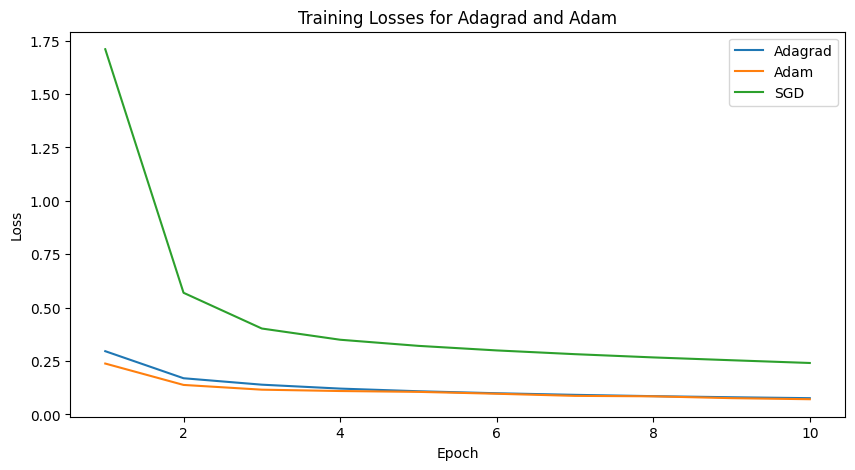

In [40]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses_adagrad, label='Adagrad')
plt.plot(range(1, num_epochs + 1), losses_adam, label='Adam')
plt.plot(range(1, num_epochs + 1), losses_sgd, label='SGD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses for Adagrad and Adam')
plt.legend()
plt.show()

### FGSM Attack
Implement FGSM attack.

In [65]:
default_epsilon = 0.15

def fgsm_attack(
    model: nn.Module, images: torch.Tensor, labels: torch.Tensor, epsilon: float = default_epsilon
) -> torch.Tensor:
    """
    Creates adversarial examples via the FGSM method:
    x_adv = x + epsilon * sign( dJ/dx ).
    """
    model.eval()
    images = images.clone().detach().to(device)
    labels = labels.to(device)

    # Ensure gradients are being tracked
    images.requires_grad = True

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    images_grad = images.grad.data.sign()
    images_adv = images + epsilon * images_grad
    images_adv = torch.clamp(images_adv, 0, 1)
    
    return images_adv.detach()

### Calculate accuracy for adversarial examples

In [66]:
correct = 0
total = 0
for images, labels in test_loader:
    # Generate adversarial images
    adv_images = fgsm_attack(model, images, labels, default_epsilon)

    # Re-classify
    outputs = model(adv_images.to(device))
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum().item()

adv_acc = 100 * correct / total
print(f"Accuracy on adversarial test images (FGSM, eps={default_epsilon}): {adv_acc:.2f}%")

Accuracy on adversarial test images (FGSM, eps=0.15): 6.03%


### Display adversarial examples

Let's compare original and adversarial images side-by-side.

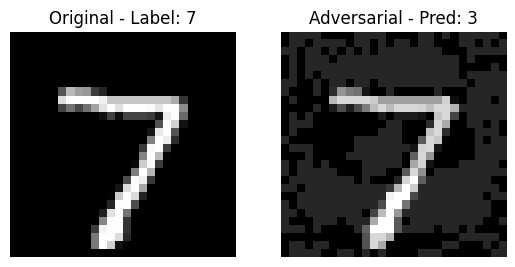

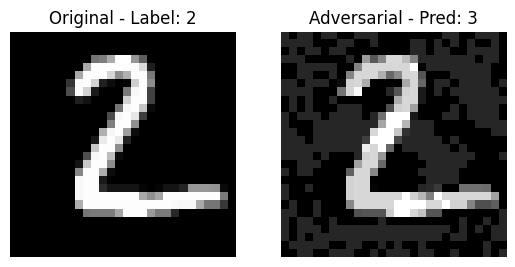

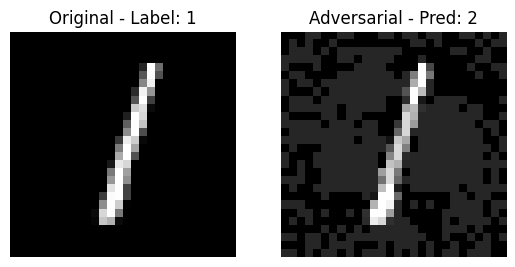

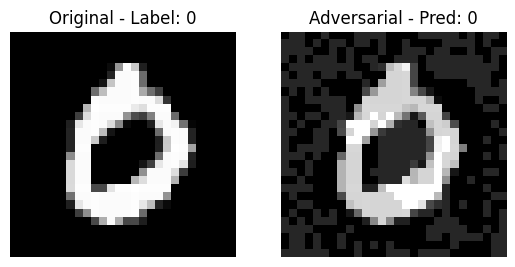

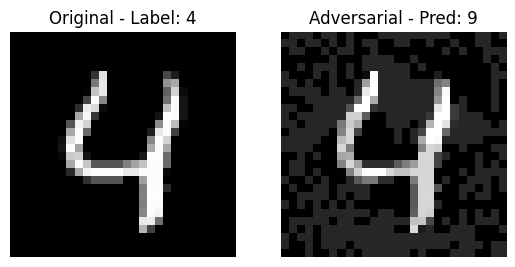

In [67]:
examples = iter(test_loader)
example_images, example_labels = next(examples)
example_images = example_images[:5]
example_labels = example_labels[:5]

adv_ex = fgsm_attack(model, example_images, example_labels, default_epsilon)

for i in range(5):
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.title(f"Original - Label: {example_labels[i].item()}")
    plt.imshow(example_images[i][0].cpu(), cmap="gray")
    plt.axis("off")

    adv_label_out = model(adv_ex[i].unsqueeze(0))
    _, adv_pred = torch.max(adv_label_out, 1)
    plt.subplot(1, 2, 2)
    plt.title(f"Adversarial - Pred: {adv_pred.item()}")
    plt.imshow(adv_ex[i][0].detach().cpu(), cmap="gray")
    plt.axis("off")

    plt.show()

### Epsilon Parameter Analysis
 In this section, you'll analyze how the epsilon parameter affects the effectiveness of adversarial examples. The epsilon parameter controls the magnitude of the perturbation applied to the original images.

**Task:**
1. Evaluate the model's accuracy on adversarial examples generated with different epsilon values (try at least 5 different values)
2. Create a line plot showing model accuracy (y-axis) vs. epsilon value (x-axis)
3. Discuss the trade-off between:
- Visual perceptibility of the perturbations (higher epsilon = more visible changes)
- Attack success rate (higher epsilon = more successful attacks = lower model accuracy)

Accuracy on adversarial test images (FGSM, eps=0.0001): 93.61%
Accuracy on adversarial test images (FGSM, eps=0.001): 93.44%
Accuracy on adversarial test images (FGSM, eps=0.01): 91.36%
Accuracy on adversarial test images (FGSM, eps=0.1): 28.50%
Accuracy on adversarial test images (FGSM, eps=0.15): 6.03%
Accuracy on adversarial test images (FGSM, eps=0.2): 0.98%
Accuracy on adversarial test images (FGSM, eps=0.25): 0.10%
Accuracy on adversarial test images (FGSM, eps=0.3): 0.00%


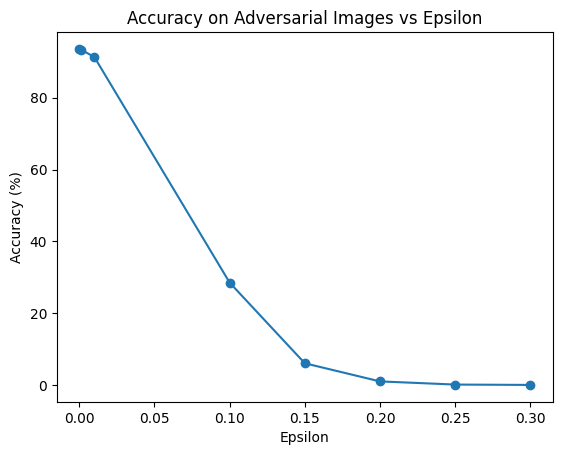

In [ ]:
# Evaluate the model's accuracy on adversarial examples generated with different epsilon values (try at least 5 different values)
epsilons = [1e-4, 1e-3, 1e-2, 1e-1, 0.15, 0.2, 0.25, 0.3]
adv_accuracies = []

for epsilon in epsilons:
    correct = 0
    total = 0
    for images, labels in test_loader:
        adv_images = fgsm_attack(model, images, labels, epsilon)
        outputs = model(adv_images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
    adv_acc = 100 * correct / total
    adv_accuracies.append(adv_acc)
    print(f"Accuracy on adversarial test images (FGSM, eps={epsilon}): {adv_acc:.2f}%")

plt.figure()
plt.plot(epsilons, adv_accuracies, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy on Adversarial Images vs Epsilon')
plt.show()